### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/timing_runs/alabama/2023_07_13_15_16_03/count_data

deaths.csv                       risk_exposure_time.hdf
deaths.hdf                       sbp_medication_person_time.csv
healthcare_visits.csv            sbp_medication_person_time.hdf
healthcare_visits.hdf            state_person_time.csv
intervention_person_time.csv     state_person_time.hdf
intervention_person_time.hdf     transition_count.csv
ldlc_medication_person_time.csv  transition_count.hdf
ldlc_medication_person_time.hdf  ylds.csv
polypill_person_time.csv         ylds.hdf
polypill_person_time.hdf         ylls.csv
risk_exposure_time.csv           ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/timing_runs/alabama/2023_07_13_15_16_03/count_data'

## Checking Stability of Risks over Time

In [4]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
person_time = person_time.loc[person_time.scenario == 'baseline']
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year','input_draw']).ptvalue.sum().reset_index()
per_time_group.head()

age     sex  year  input_draw       ptvalue
0  25_to_29  Female  2023          29  10781.284052
1  25_to_29  Female  2023         232  10717.963039
2  25_to_29  Female  2023         357  10797.152635
3  25_to_29  Female  2023         394  10706.540726
4  25_to_29  Female  2023         602  10656.405202

In [5]:
%%capture
for sex in per_time_group.sex.unique():
    for age in per_time_group.age.unique():
        plt.figure() 
        subdata = per_time_group.loc[(per_time_group.sex==sex) & (per_time_group.age==age)]
        plt.plot(subdata['year'], subdata['ptvalue'], marker='o')
        #plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Person Time: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,300000)
        plt.grid()

### BMI

In [6]:
risk_exp = pd.read_csv(sim_results_dir + '/risk_exposure_time.csv')
risk_exp.head()

Unnamed: 0     sex  year                            risk  \
0           0  Female  2023  high_body_mass_index_in_adults   
1           1  Female  2023  high_body_mass_index_in_adults   
2           2  Female  2023  high_body_mass_index_in_adults   
3           3  Female  2023  high_body_mass_index_in_adults   
4           4  Female  2023  high_body_mass_index_in_adults   

              measure  input_draw       scenario       age          value  
0  risk_exposure_time          29       baseline  25_to_29  333161.726802  
1  risk_exposure_time          29  lifestyle_100  25_to_29  333161.726802  
2  risk_exposure_time          29   outreach_100  25_to_29  333161.726802  
3  risk_exposure_time          29   polypill_100  25_to_29  333161.726802  
4  risk_exposure_time          29       baseline  30_to_34  337865.876916

In [7]:
bmi_exp = risk_exp.loc[(risk_exp['risk']=='high_body_mass_index_in_adults') & (risk_exp['scenario']=='baseline')]
bmi_exp.head()

Unnamed: 0     sex  year                            risk  \
0            0  Female  2023  high_body_mass_index_in_adults   
4            4  Female  2023  high_body_mass_index_in_adults   
8            8  Female  2023  high_body_mass_index_in_adults   
12          12  Female  2023  high_body_mass_index_in_adults   
16          16  Female  2023  high_body_mass_index_in_adults   

               measure  input_draw  scenario       age          value  
0   risk_exposure_time          29  baseline  25_to_29  333161.726802  
4   risk_exposure_time          29  baseline  30_to_34  337865.876916  
8   risk_exposure_time          29  baseline  35_to_39  321954.881787  
12  risk_exposure_time          29  baseline  40_to_44  313923.577548  
16  risk_exposure_time          29  baseline  45_to_49  319237.641660

In [8]:
bmi_exp_summ = (bmi_exp
                .groupby(['age', 'sex', 'year'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
bmi_exp_summ.head()

age     sex  year           mean           2.5%          97.5%
0  25_to_29  Female  2023  329600.024604  325533.913945  333043.877741
1  25_to_29  Female  2024  325889.127635  322430.947389  329977.776432
2  25_to_29  Female  2025  322660.923606  319381.482739  328392.619982
3  25_to_29  Female  2026  320746.022443  316408.830782  329191.664393
4  25_to_29  Female  2027  319425.748571  315864.038663  326468.223995

In [9]:
%%capture
for sex in bmi_exp_summ.sex.unique():
    for age in bmi_exp_summ.age.unique():
        plt.figure() 
        subdata = bmi_exp_summ.loc[(bmi_exp_summ.sex==sex) & (bmi_exp_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'BMI Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

In [10]:
bmi_exp_rate = bmi_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
bmi_exp_rate = pd.concat([bmi_exp_rate, per_time_group.ptvalue], axis=1)
bmi_exp_rate['bmi_rate'] = bmi_exp_rate['value'] / bmi_exp_rate['ptvalue']

In [11]:
bmi_exp_rate_summ = (bmi_exp_rate
                .groupby(['age', 'sex', 'year'])
                .bmi_rate.describe(percentiles=[.025,0.5, .975])
                .filter(['mean', '50%','2.5%', '97.5%'])
                .reset_index())
bmi_exp_rate_summ.head()

age     sex  year       mean        50%       2.5%      97.5%
0  25_to_29  Female  2023  30.714180  30.742818  30.349128  31.018834
1  25_to_29  Female  2024  30.715637  30.737881  30.377393  30.965794
2  25_to_29  Female  2025  30.703570  30.747132  30.389389  30.907425
3  25_to_29  Female  2026  30.696074  30.756171  30.362725  30.930905
4  25_to_29  Female  2027  30.707571  30.699435  30.365209  30.977284

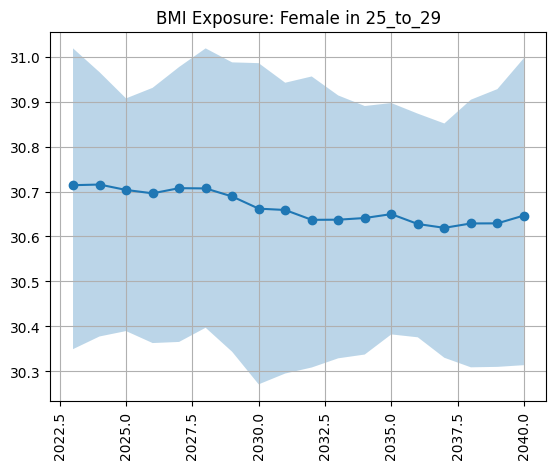

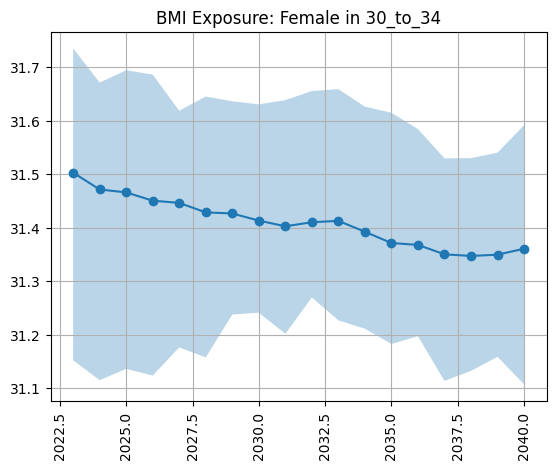

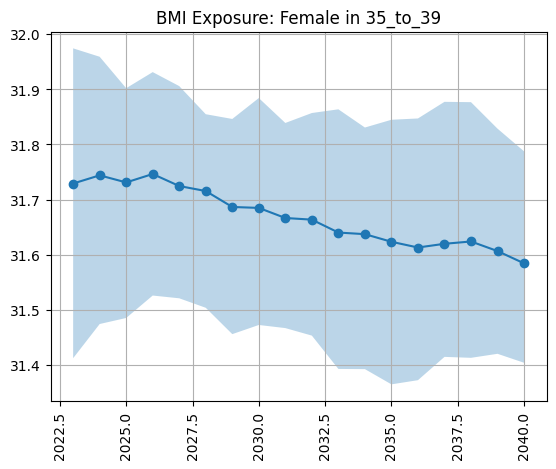

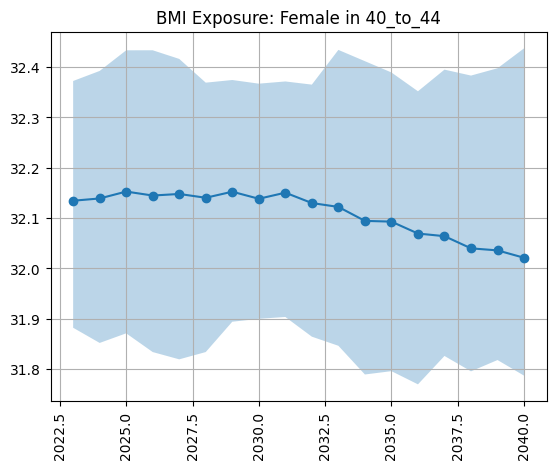

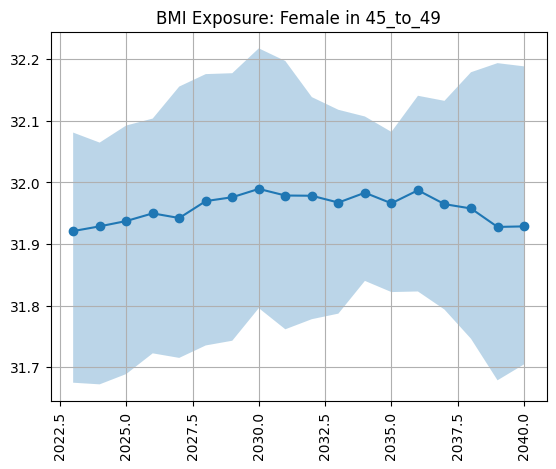

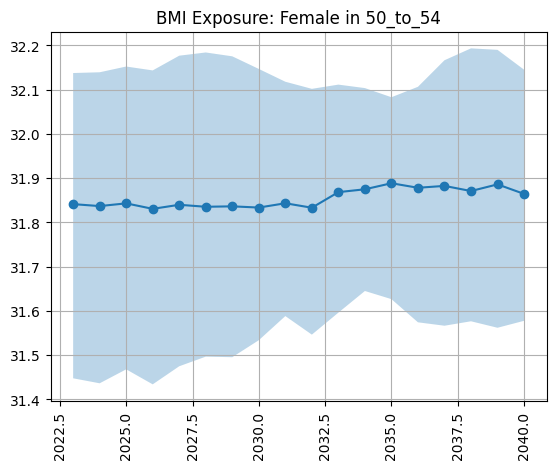

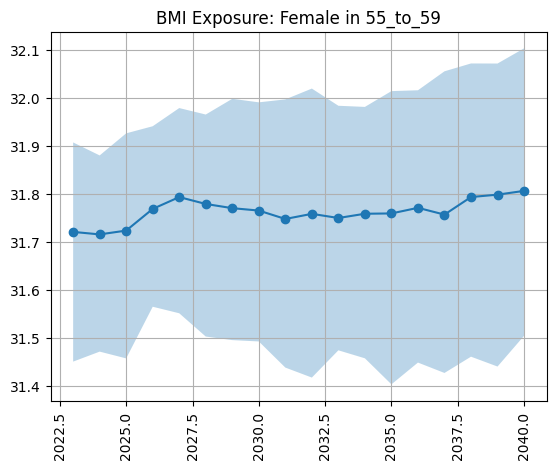

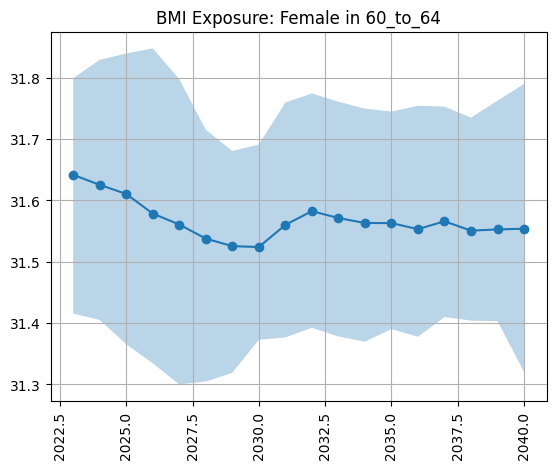

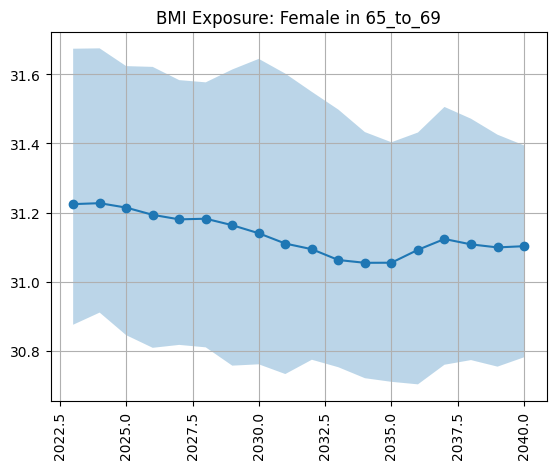

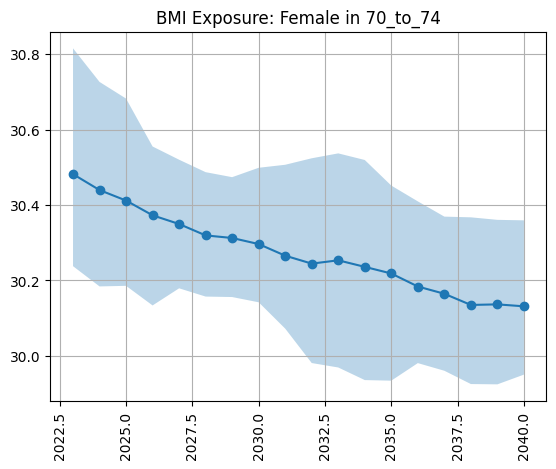

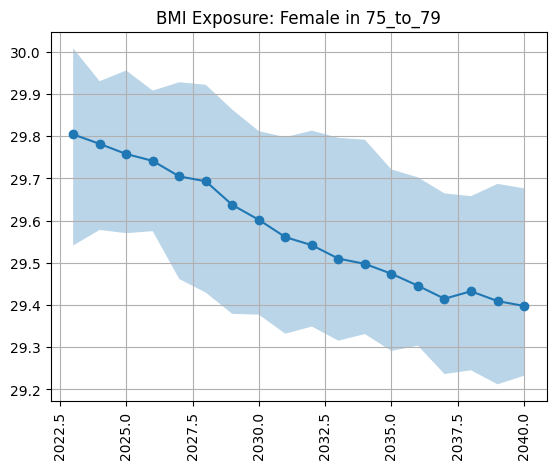

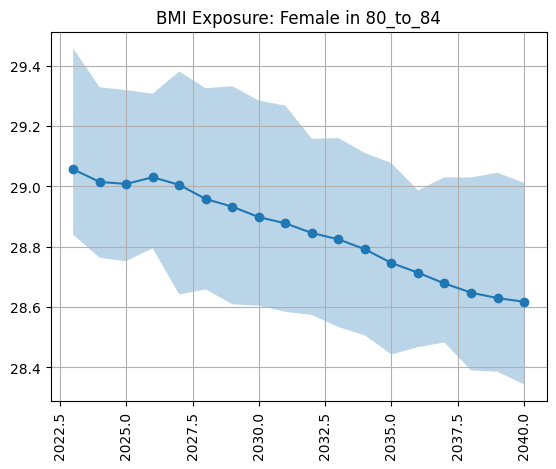

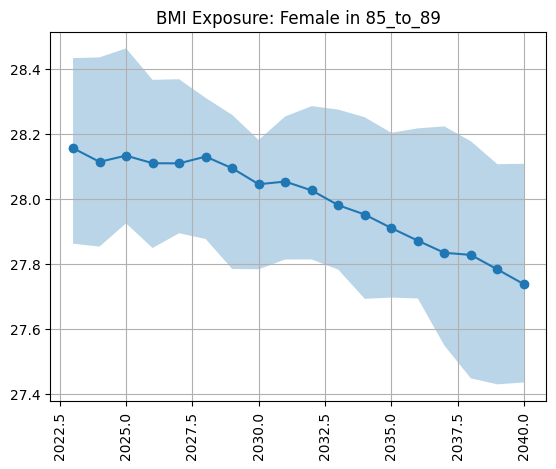

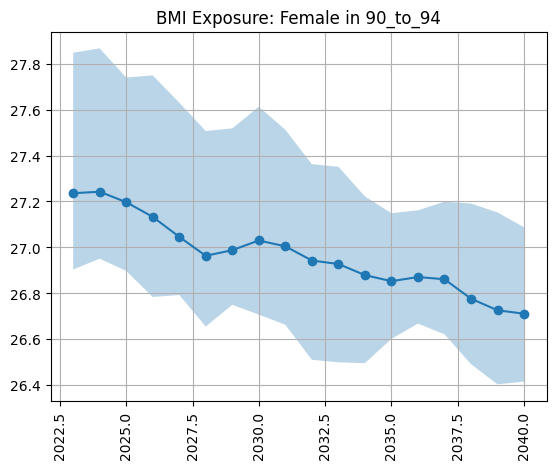

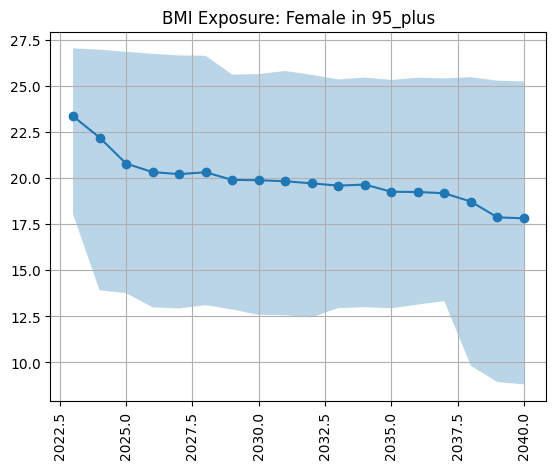

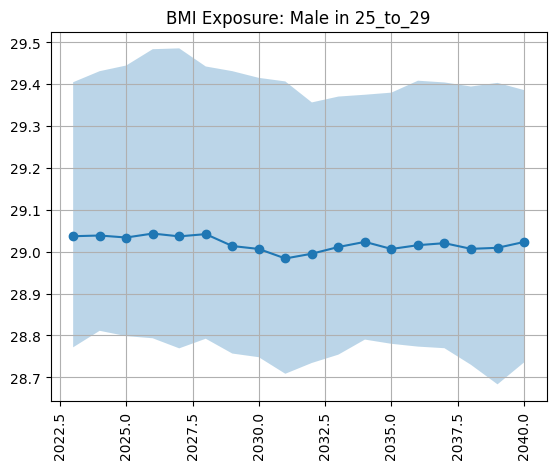

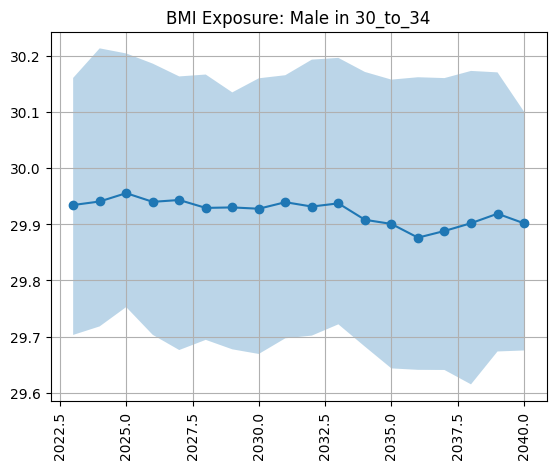

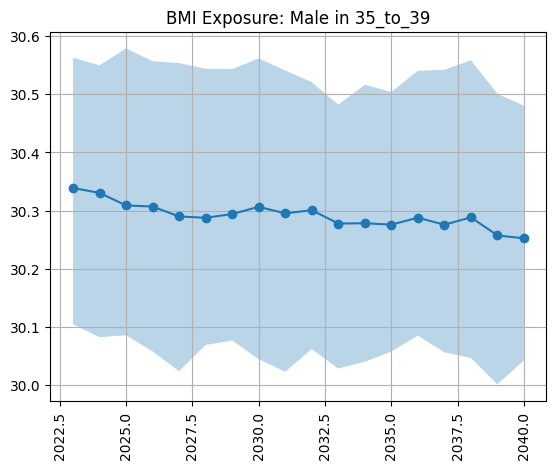

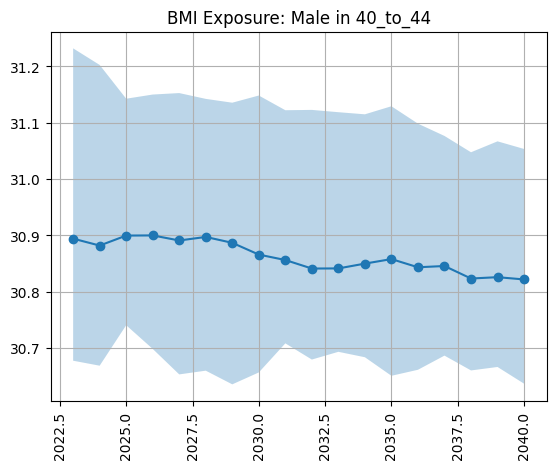

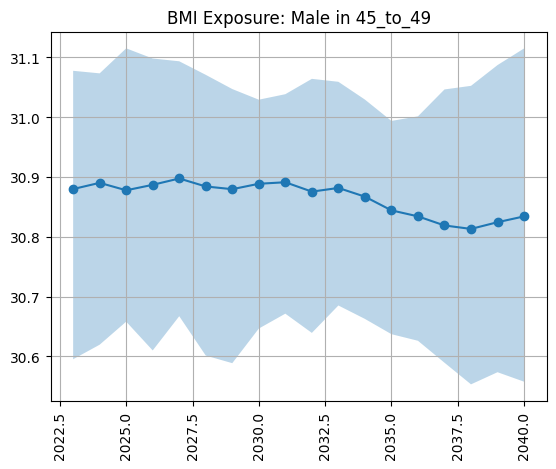

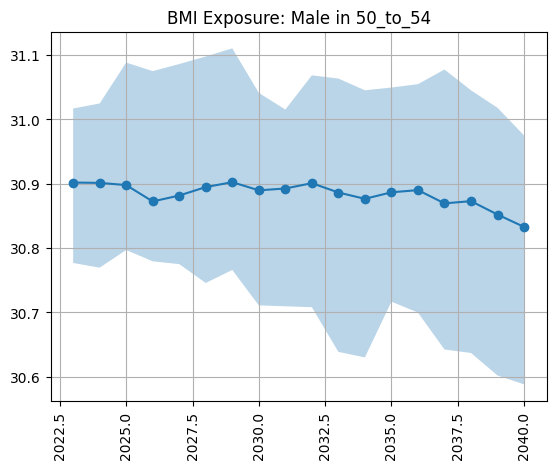

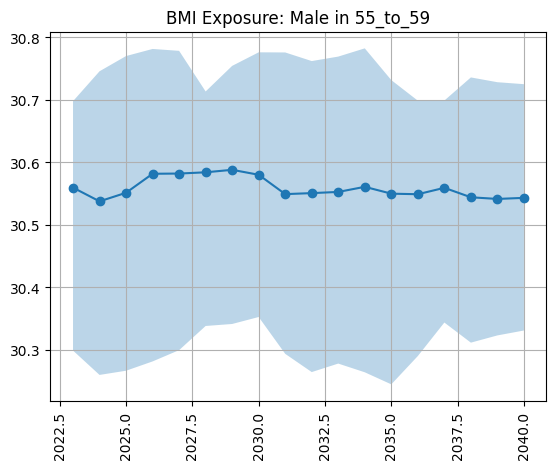

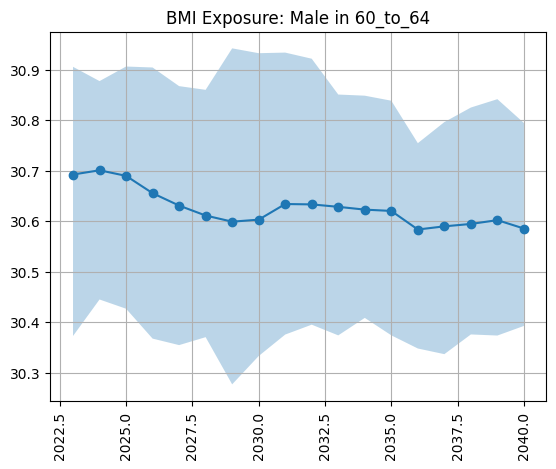

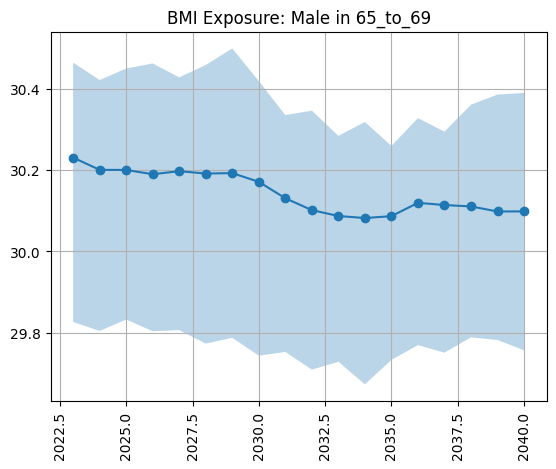

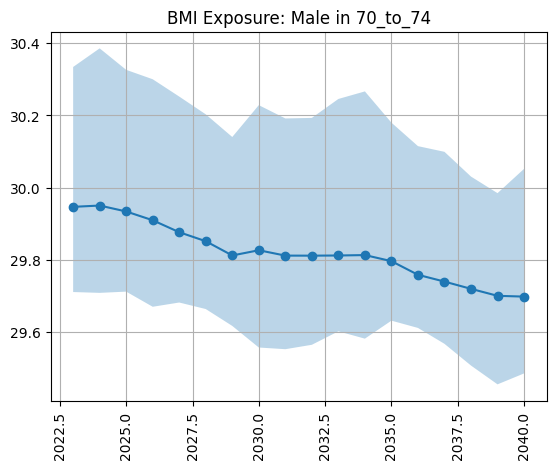

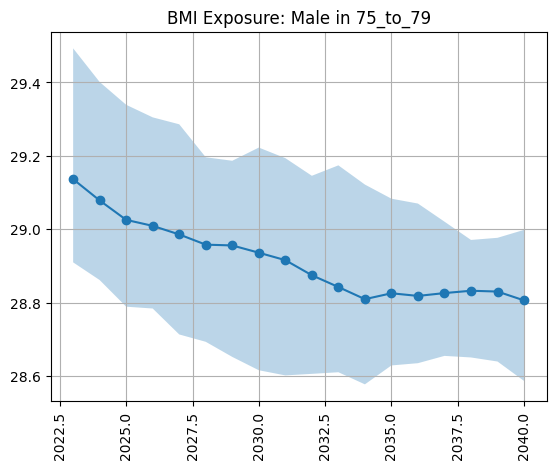

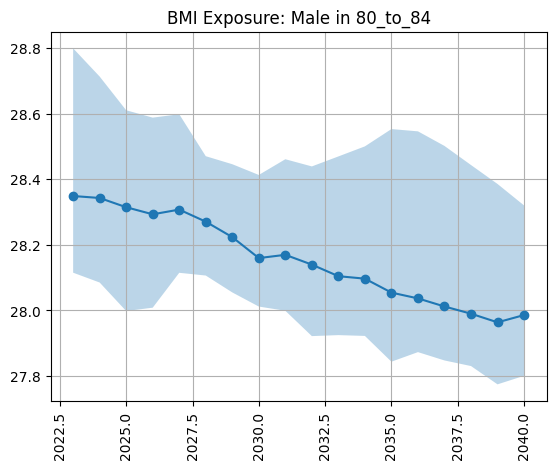

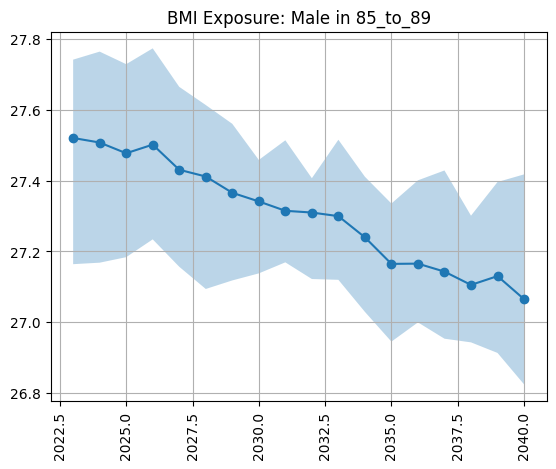

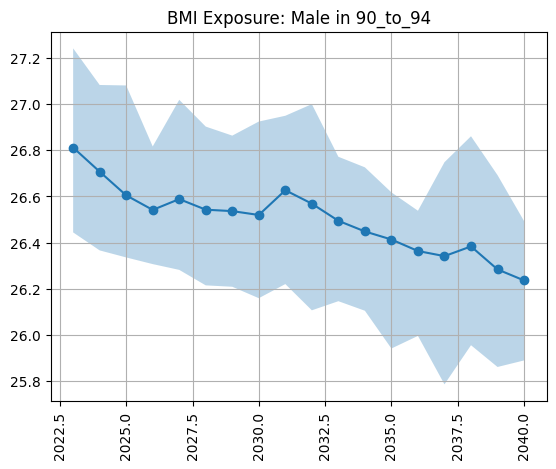

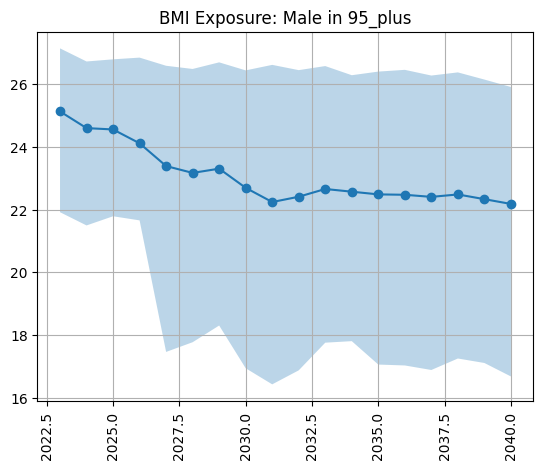

In [12]:
#%%capture
for sex in bmi_exp_rate_summ.sex.unique():
    for age in bmi_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'BMI Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(20,33)
        plt.grid()

Older people are getting lower BMI's overtime - that is bad 

### SBP 

In [13]:
sbp_exp = risk_exp.loc[(risk_exp['risk']=='high_systolic_blood_pressure') & (risk_exp['scenario']=='baseline')]
sbp_exp_rate = sbp_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
sbp_exp_rate = pd.concat([sbp_exp_rate, per_time_group.ptvalue], axis=1)
sbp_exp_rate['sbp_rate'] = sbp_exp_rate['value'] / sbp_exp_rate['ptvalue']

In [14]:
sbp_exp_rate_summ = (sbp_exp_rate
                .groupby(['age', 'sex', 'year'])
                .sbp_rate.describe(percentiles=[.025, .975])
                .filter(['mean','50%', '2.5%', '97.5%'])
                .reset_index())
sbp_exp_rate_summ.head()

age     sex  year        mean         50%        2.5%       97.5%
0  25_to_29  Female  2023  109.839506  109.911598  107.584388  112.520816
1  25_to_29  Female  2024  109.831796  109.968065  107.600867  112.397405
2  25_to_29  Female  2025  109.860919  110.007936  107.615660  112.406200
3  25_to_29  Female  2026  109.847757  109.992936  107.622157  112.409202
4  25_to_29  Female  2027  109.849651  109.810054  107.672353  112.432660

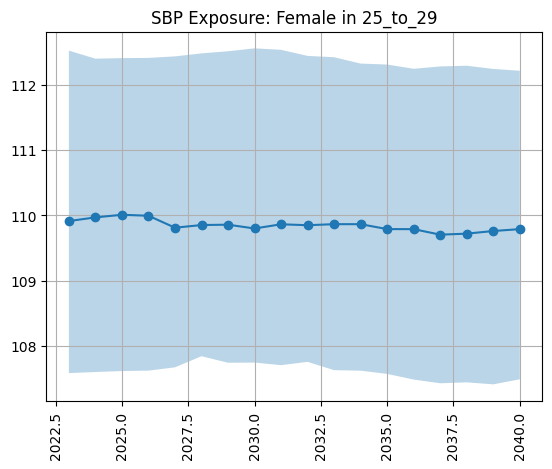

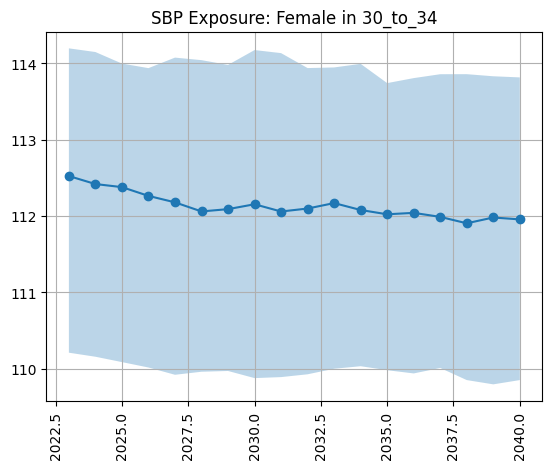

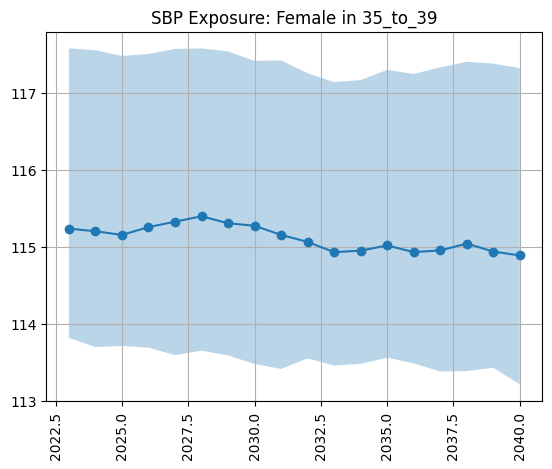

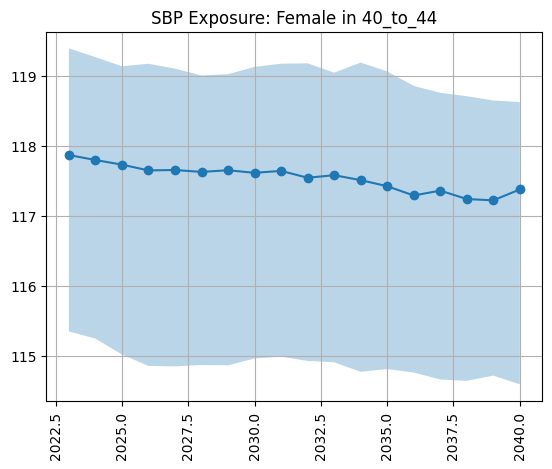

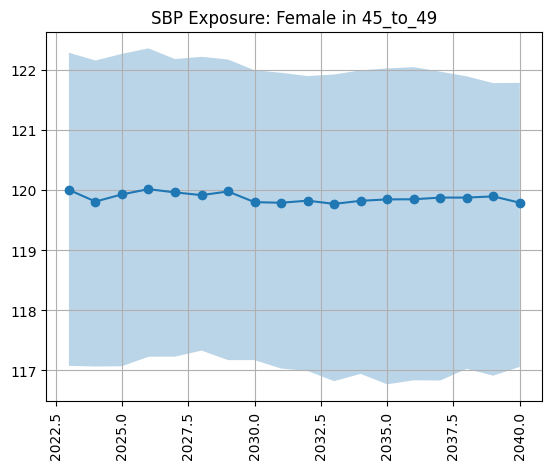

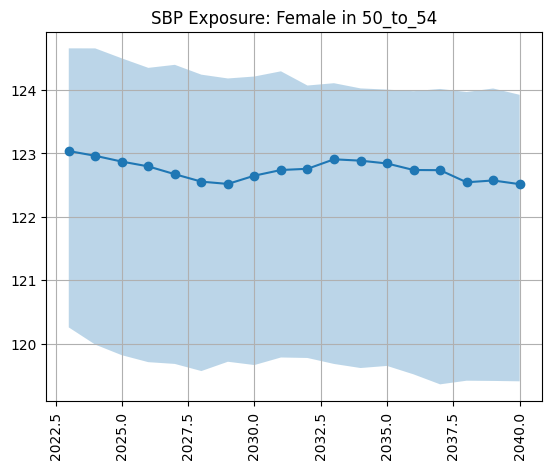

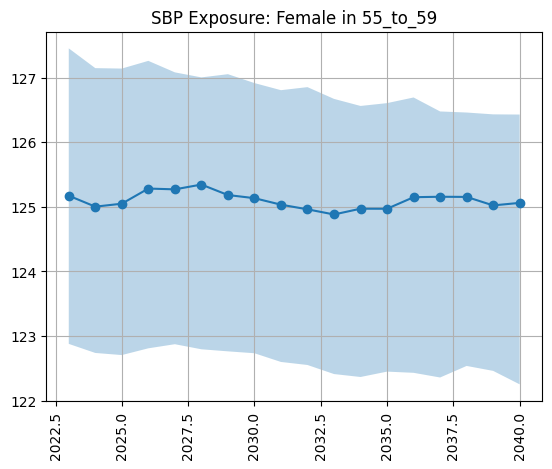

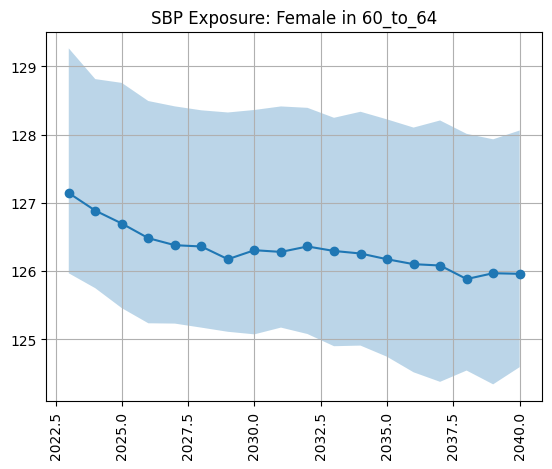

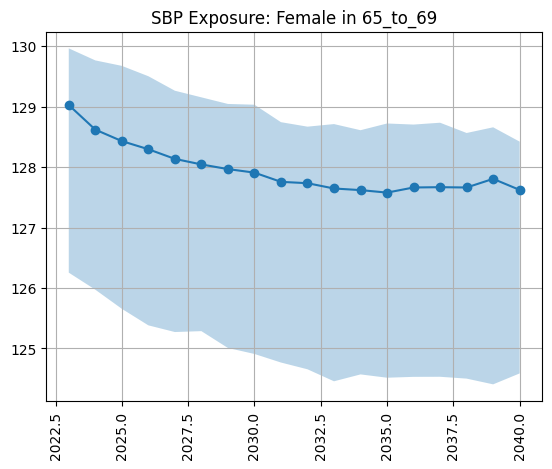

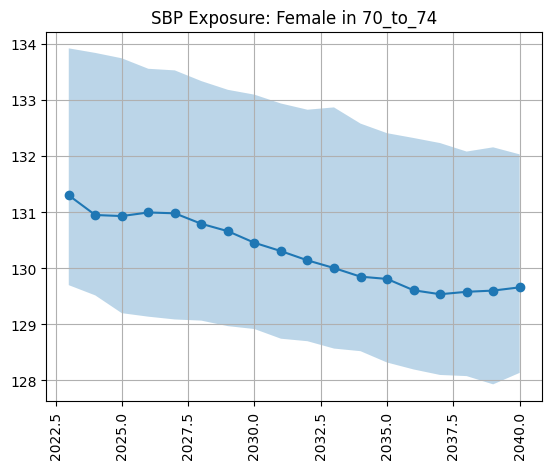

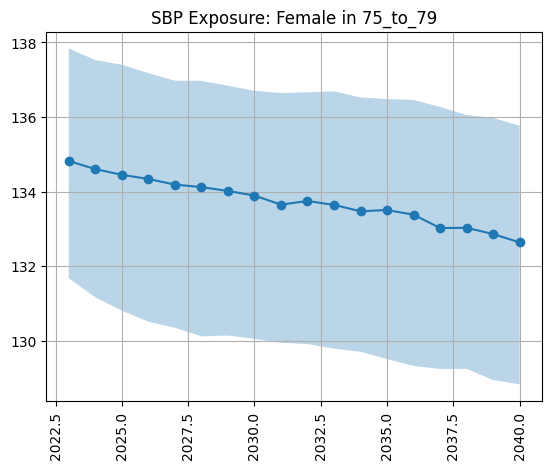

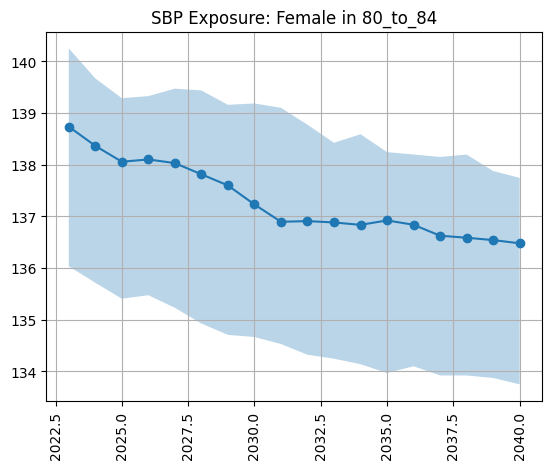

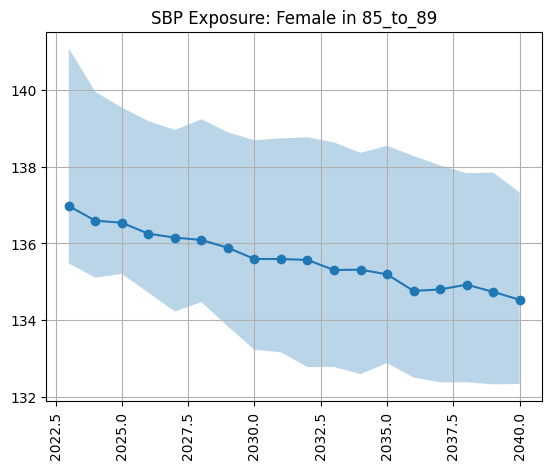

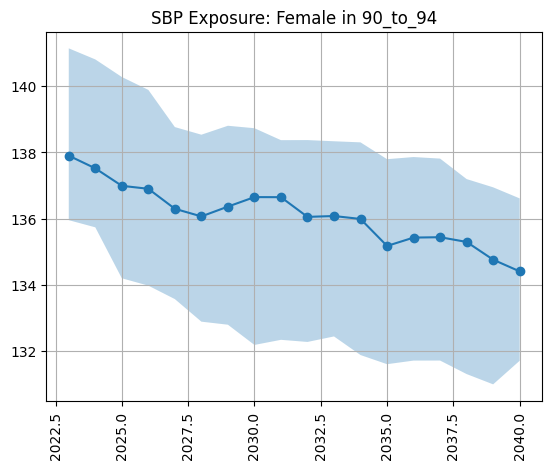

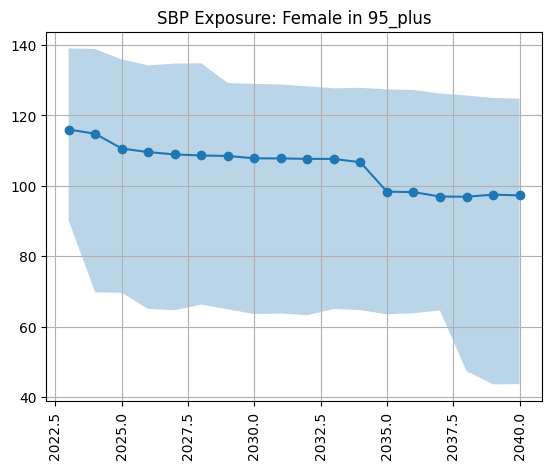

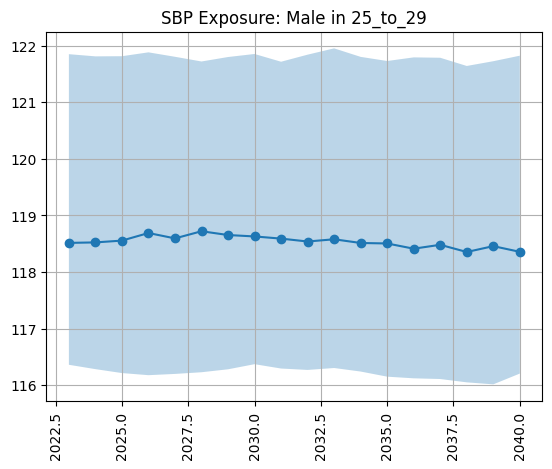

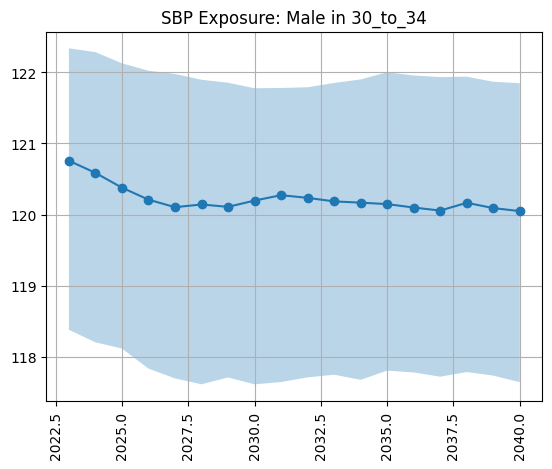

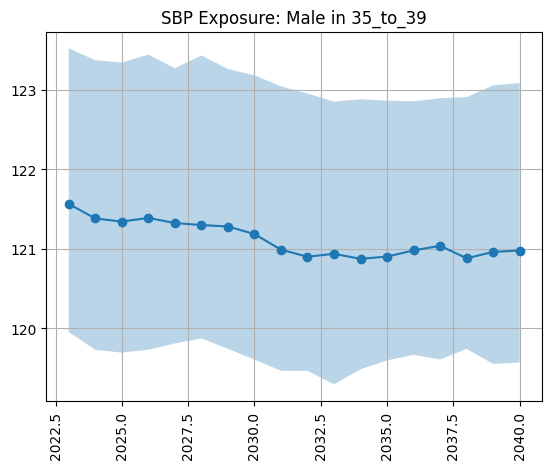

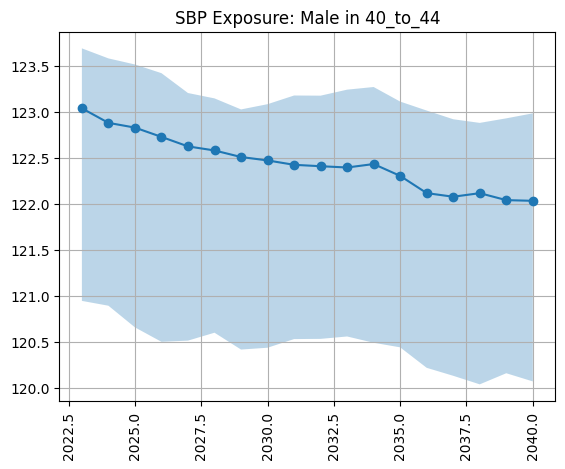

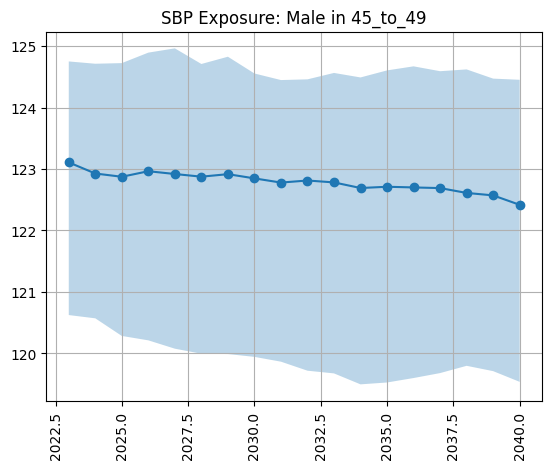

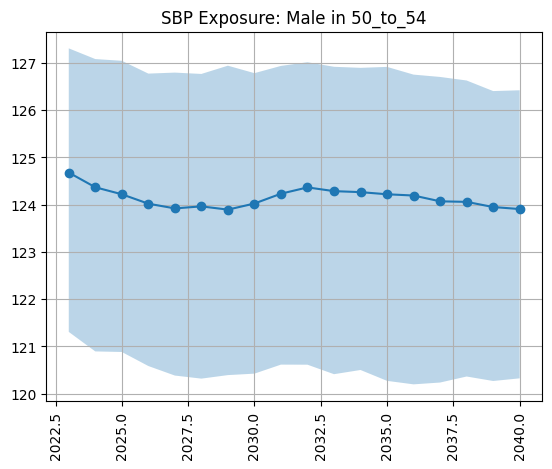

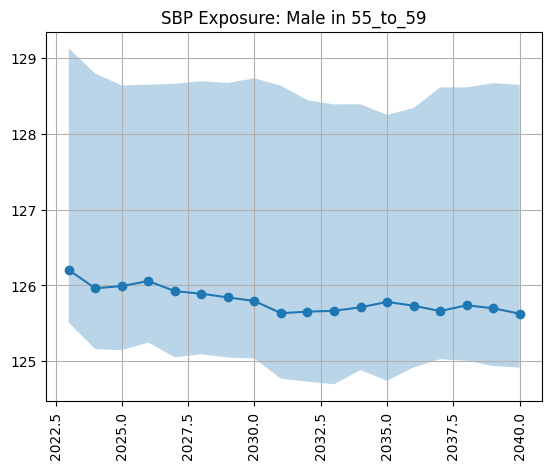

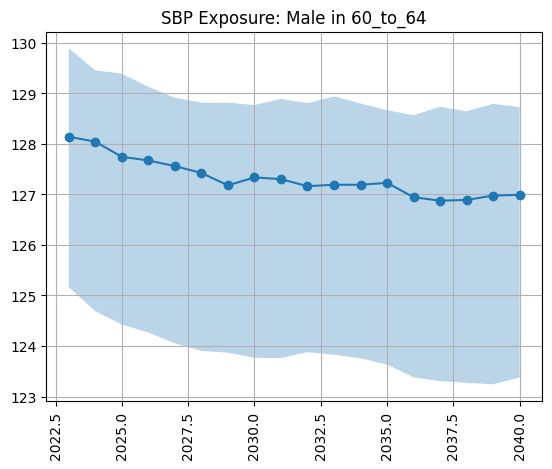

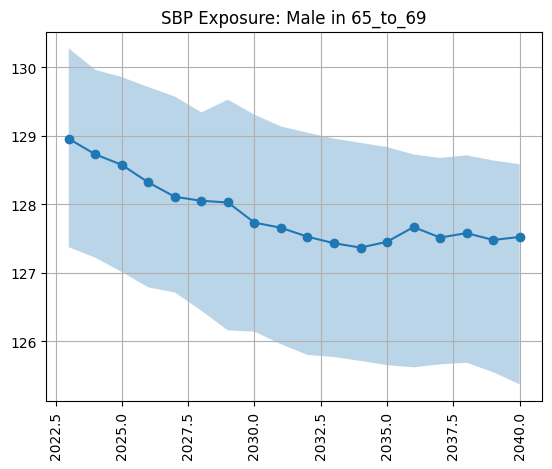

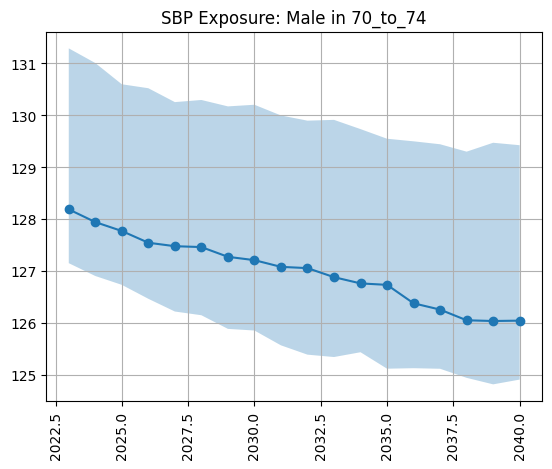

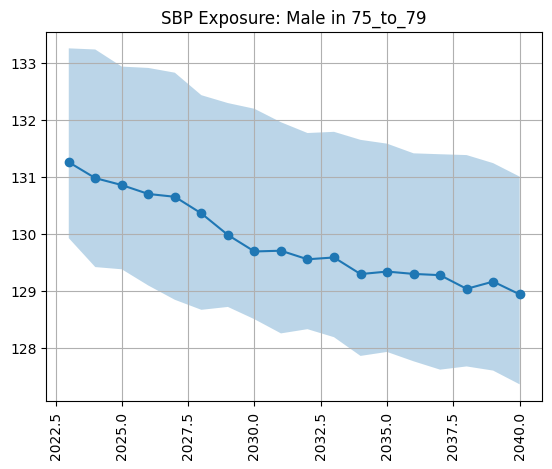

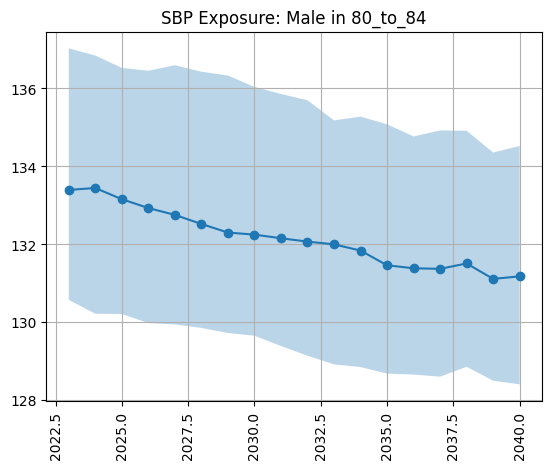

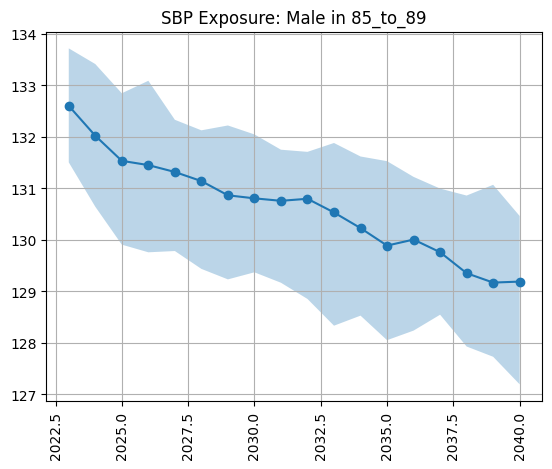

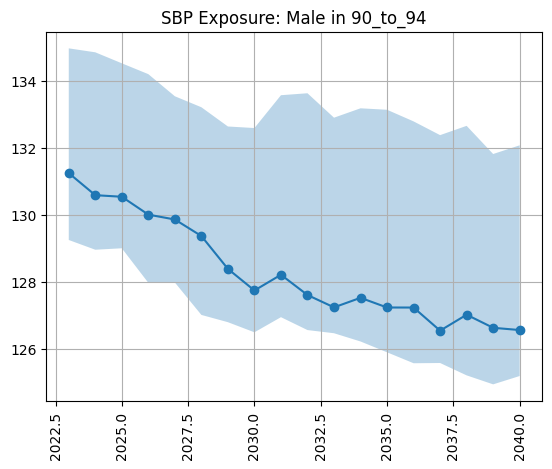

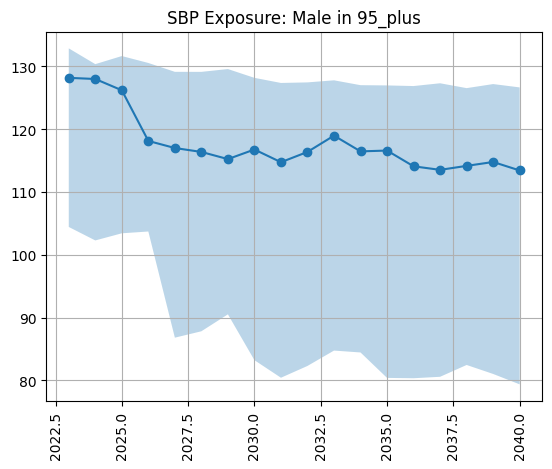

In [15]:
#%%capture
for sex in sbp_exp_rate_summ.sex.unique():
    for age in sbp_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['50%'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

This one is decreasing over time as well... 

### LDL-C

In [16]:
ldl_exp = risk_exp.loc[(risk_exp['risk']=='high_ldl_cholesterol') & (risk_exp['scenario']=='baseline')]
ldl_exp_rate = ldl_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
ldl_exp_rate = pd.concat([ldl_exp_rate, per_time_group.ptvalue], axis=1)
ldl_exp_rate['ldl_rate'] = ldl_exp_rate['value'] / ldl_exp_rate['ptvalue']
ldl_exp_rate_summ = (ldl_exp_rate
                .groupby(['age', 'sex', 'year'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_exp_rate_summ.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  Female  2023  2.630446  2.546724  2.795383
1  25_to_29  Female  2024  2.629765  2.544077  2.795281
2  25_to_29  Female  2025  2.630392  2.552054  2.797855
3  25_to_29  Female  2026  2.631060  2.549043  2.799408
4  25_to_29  Female  2027  2.632135  2.553673  2.799294

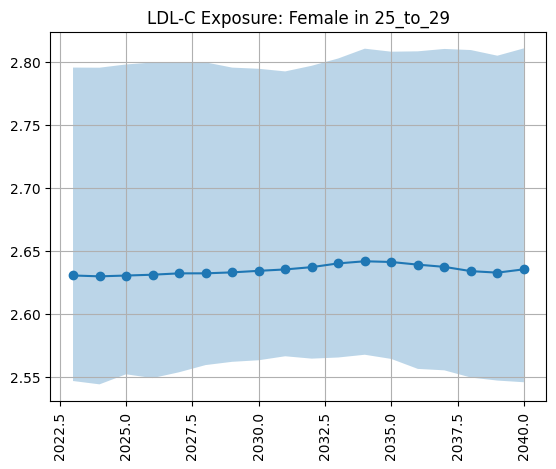

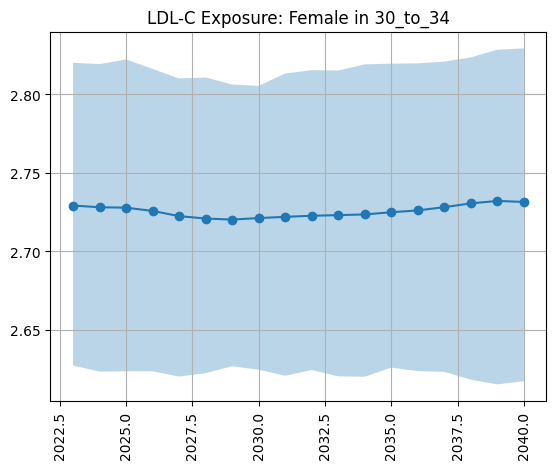

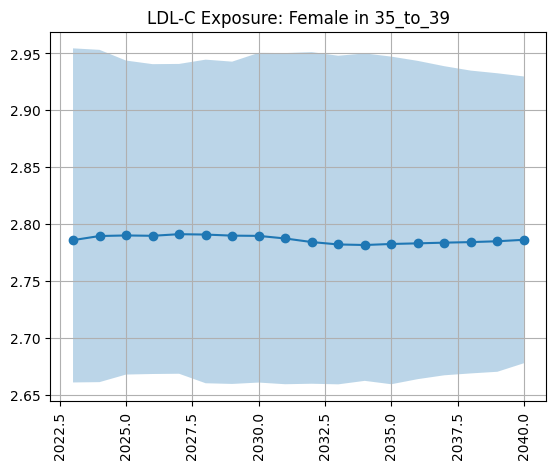

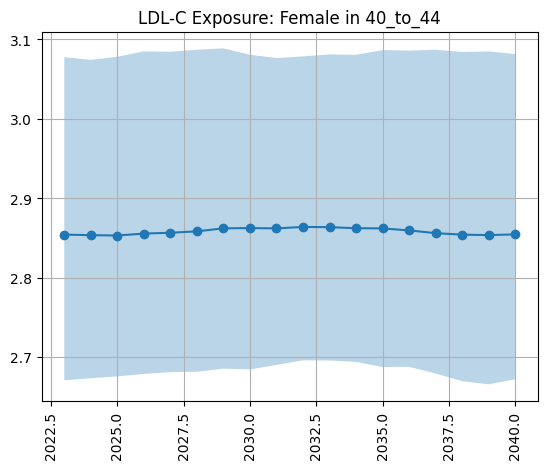

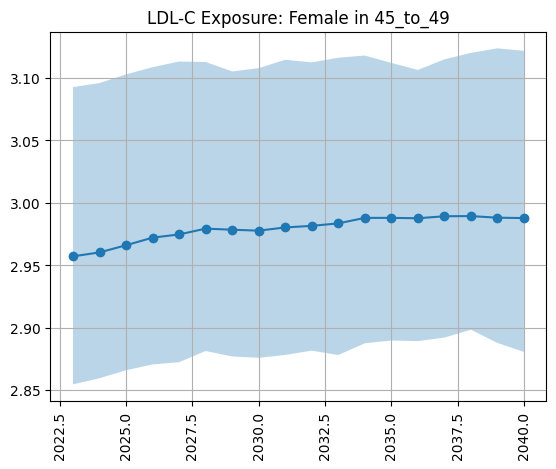

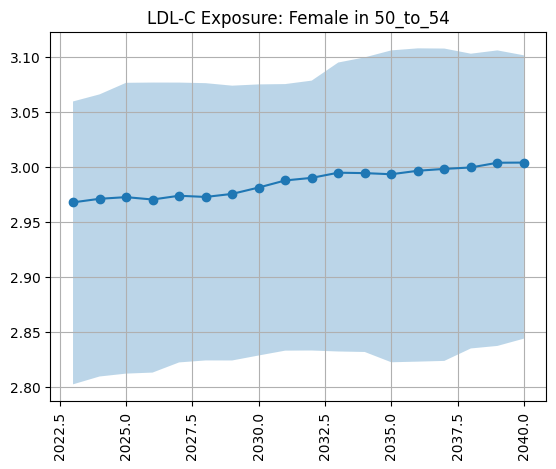

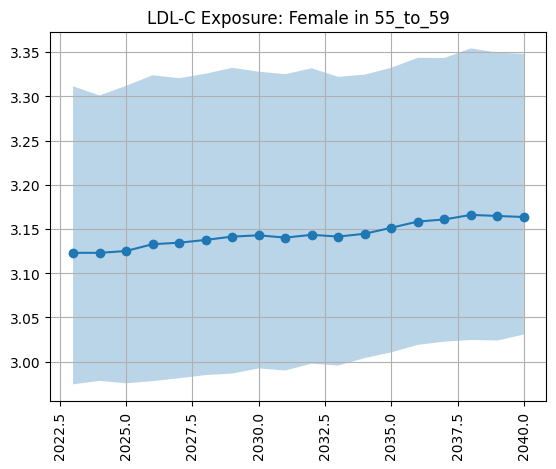

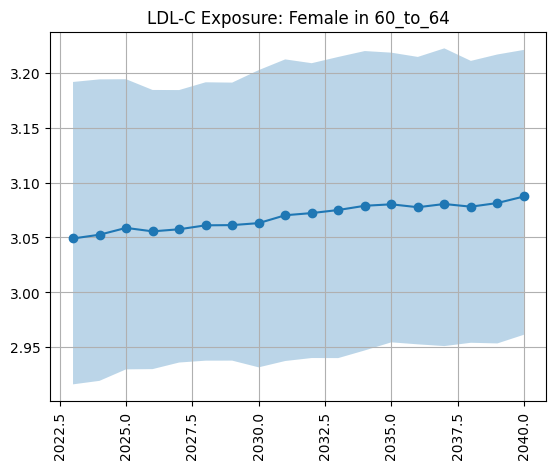

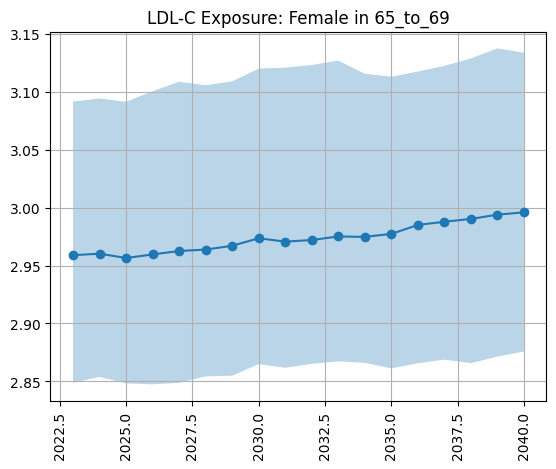

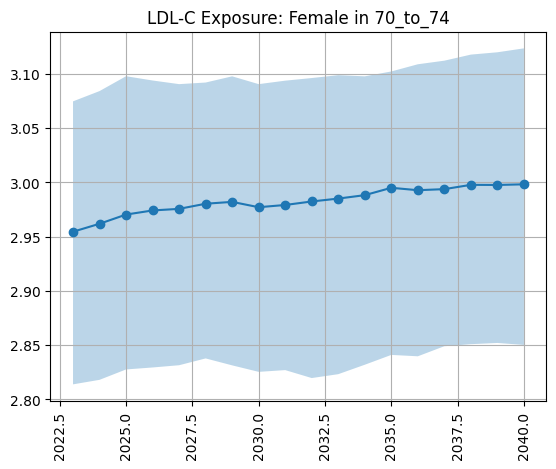

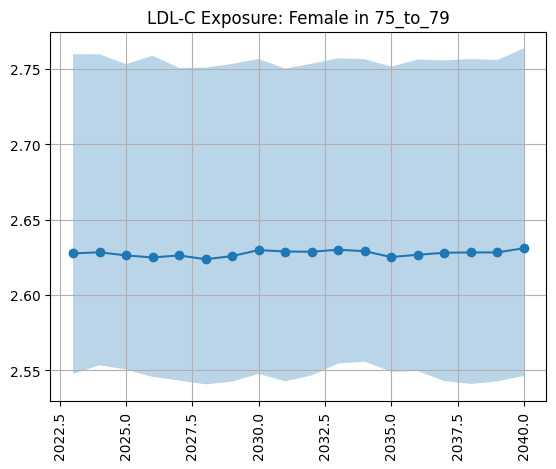

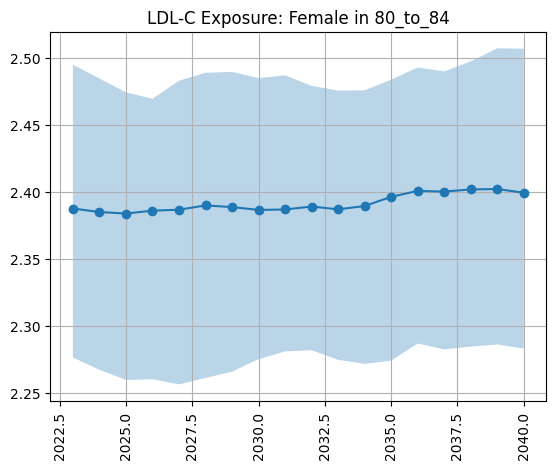

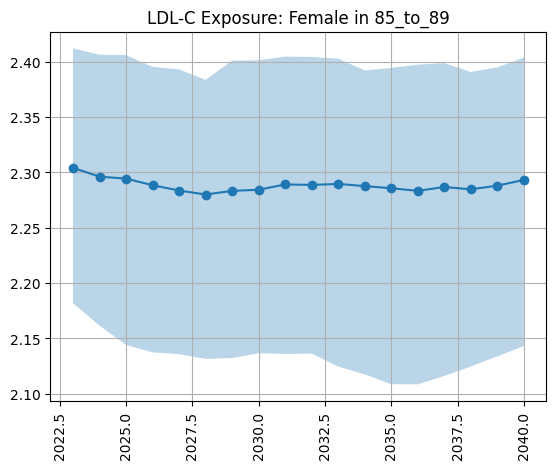

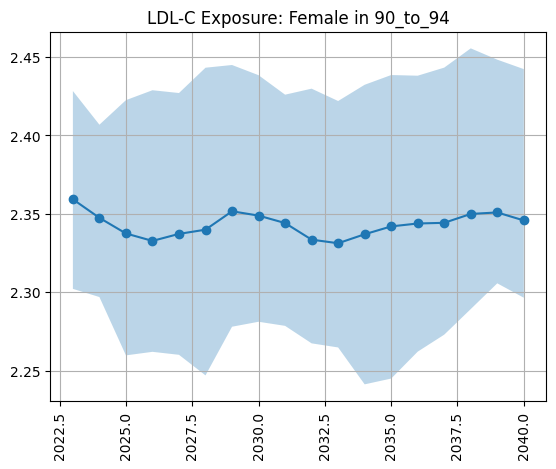

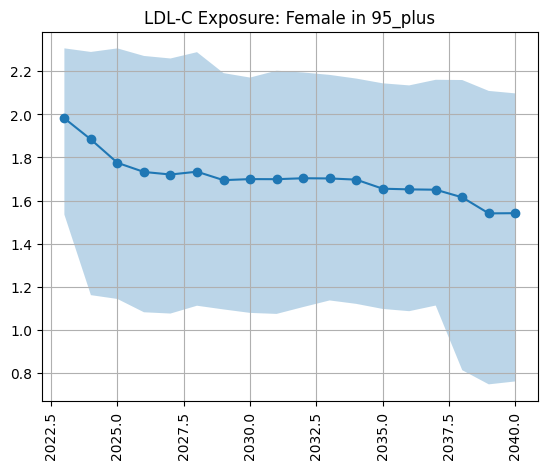

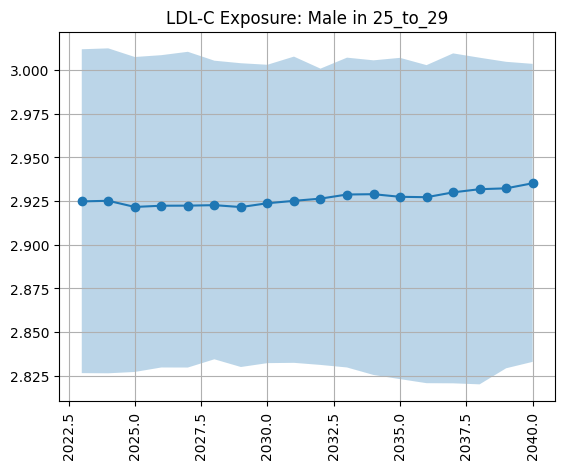

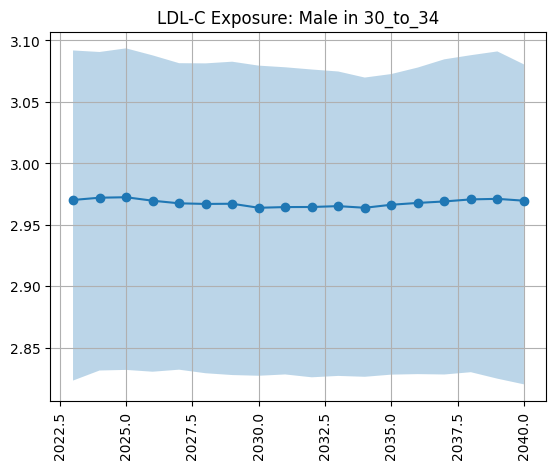

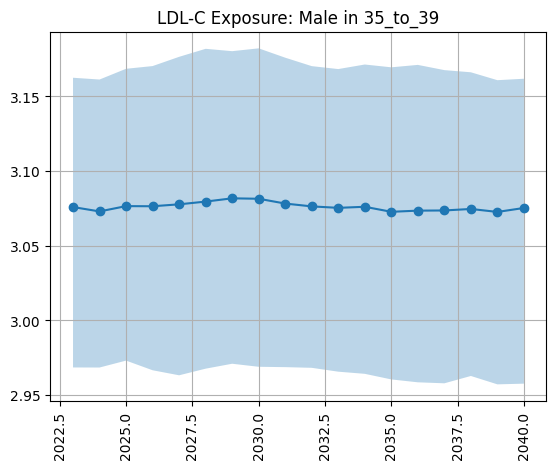

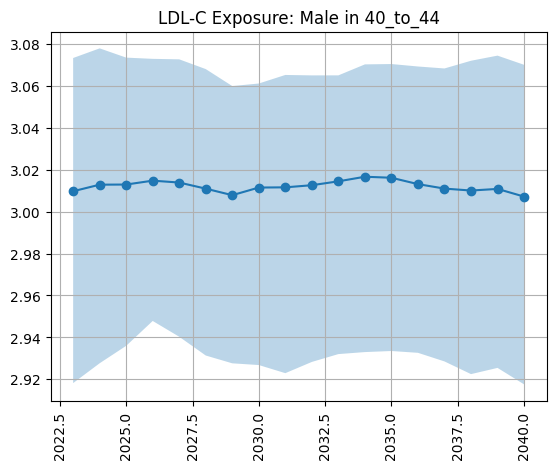

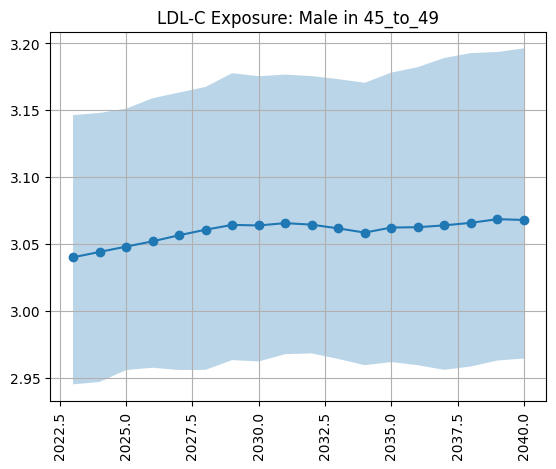

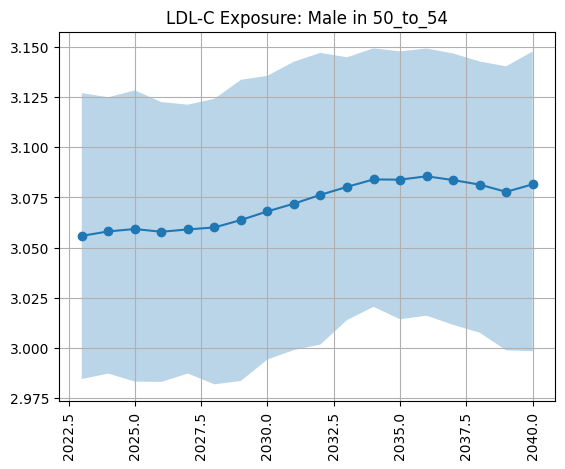

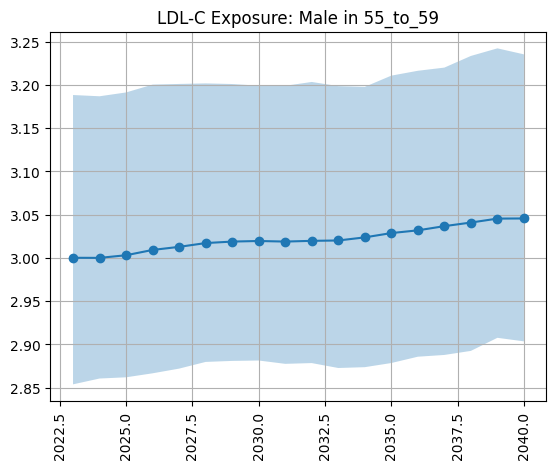

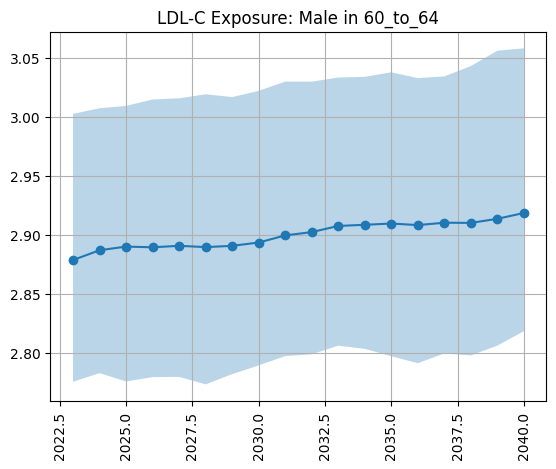

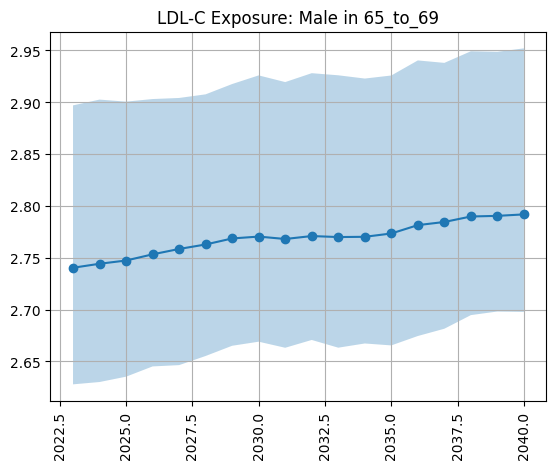

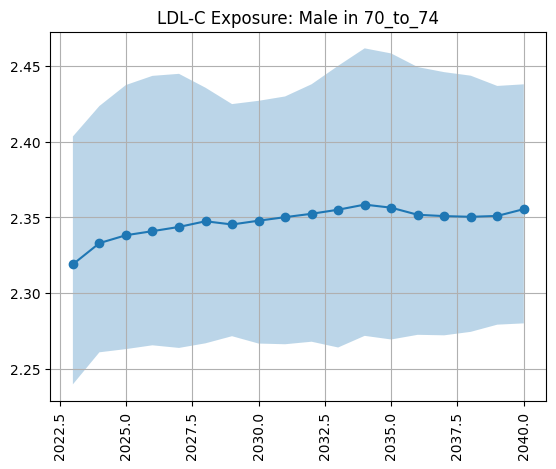

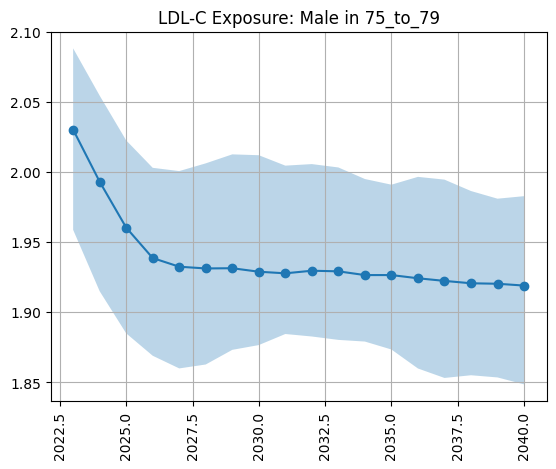

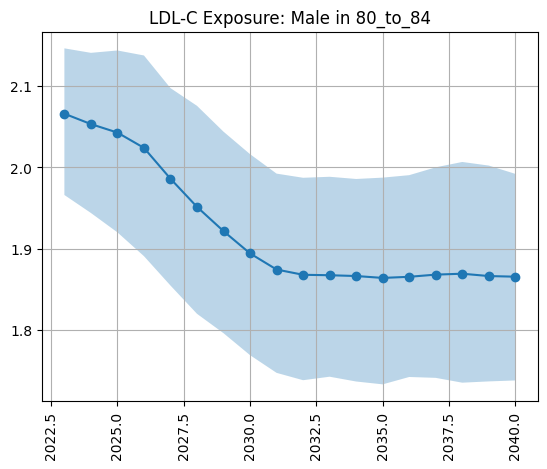

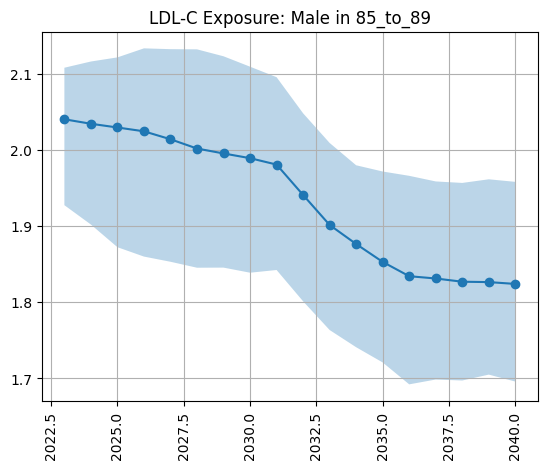

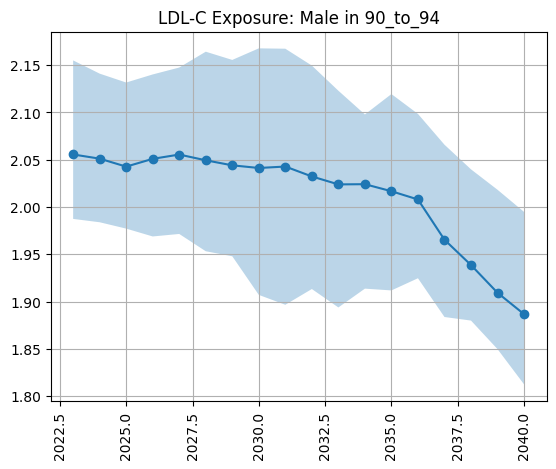

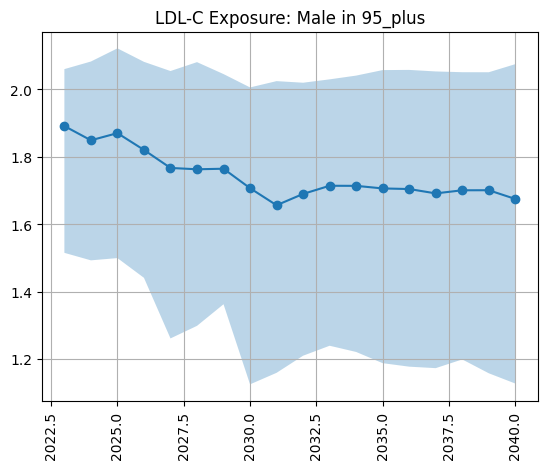

In [17]:
#%%capture
for sex in ldl_exp_rate_summ.sex.unique():
    for age in ldl_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'LDL-C Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

LDL-C increases in some age groups but decreases in the oldest age groups 

### FPG

In [18]:
fpg_exp = risk_exp.loc[(risk_exp['risk']=='high_fasting_plasma_glucose')  & (risk_exp['scenario']=='baseline')]
fpg_exp_rate = fpg_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
fpg_exp_rate = pd.concat([fpg_exp_rate, per_time_group.ptvalue], axis=1)
fpg_exp_rate['fpg_rate'] = fpg_exp_rate['value'] / fpg_exp_rate['ptvalue']
fpg_exp_rate_summ = (fpg_exp_rate
                .groupby(['age', 'sex', 'year'])
                .fpg_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
fpg_exp_rate_summ.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  Female  2023  5.340611  4.853927  6.192818
1  25_to_29  Female  2024  5.337932  4.839540  6.195073
2  25_to_29  Female  2025  5.338955  4.839992  6.188857
3  25_to_29  Female  2026  5.339950  4.843549  6.183905
4  25_to_29  Female  2027  5.337043  4.833833  6.190216

In [19]:
%%capture
for sex in fpg_exp_rate_summ.sex.unique():
    for age in fpg_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'FPG Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

Even more interestingly, this one looks good and very stable over time 

## Comparison to Artifacts

In [20]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613/

alabama.hdf               logs/               ohio.hdf
alaska.hdf                louisiana.hdf       oklahoma.hdf
arizona.hdf               maine.hdf           oregon.hdf
arkansas.hdf              maryland.hdf        paf-calculations/
california.hdf            massachusetts.hdf   pennsylvania.hdf
colorado.hdf              michigan.hdf        rhode_island.hdf
connecticut.hdf           minnesota.hdf       south_carolina.hdf
delaware.hdf              mississippi.hdf     south_dakota.hdf
district_of_columbia.hdf  missouri.hdf        south_dakotatennessee.hdf
florida.hdf               montana.hdf         tennessee.hdf
georgia.hdf               nebraska.hdf        texas.hdf
hawaii.hdf                nevada.hdf          utah.hdf
idaho.hdf                 new_hampshire.hdf   vermont.hdf
illinois.hdf              new_jersey.hdf      virginia.hdf
indiana.hdf               new_mexico.hdf      washington.hdf
iowa.hdf                  new_york.hdf        west_virginia.hdf
kansas.hdf                

In [21]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [22]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        #data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_946']]

        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.5, 0.975], axis=1).filter(['mean', '50%', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        #data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

### BMI

In [23]:
bmi_art = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure')
#bmi_art.reset_index(inplace=True)
bmi_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_art.age_start,bmi_art.age_end)]
#bmi_art['sex'] = np.where(bmi_art['sex'] == 'Female', 'female', 'male')
bmi_art.head()

sex  age_start  age_end  year_start  year_end   parameter       mean  \
0  Female       25.0     30.0        2019      2020  continuous  30.899912   
1  Female       30.0     35.0        2019      2020  continuous  31.636913   
2  Female       35.0     40.0        2019      2020  continuous  31.883495   
3  Female       40.0     45.0        2019      2020  continuous  32.130649   
4  Female       45.0     50.0        2019      2020  continuous  32.169931   

         50%       2.5%      97.5% location   measure age_group  
0  30.892990  30.572156  31.233780  Alabama  exposure  25_to_29  
1  31.638236  31.293987  31.989474  Alabama  exposure  30_to_34  
2  31.884883  31.555235  32.210906  Alabama  exposure  35_to_39  
3  32.123262  31.801051  32.462829  Alabama  exposure  40_to_44  
4  32.165649  31.855765  32.505542  Alabama  exposure  45_to_49

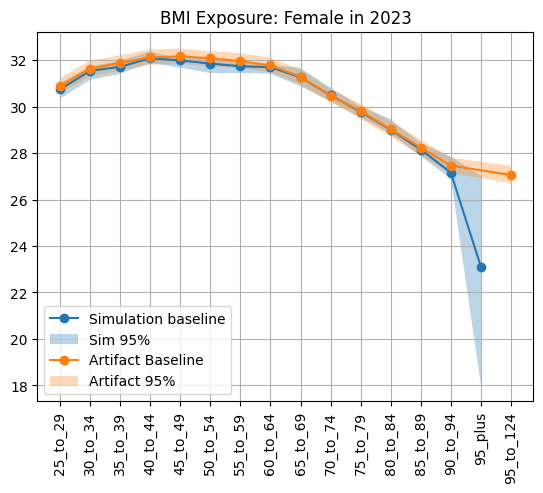

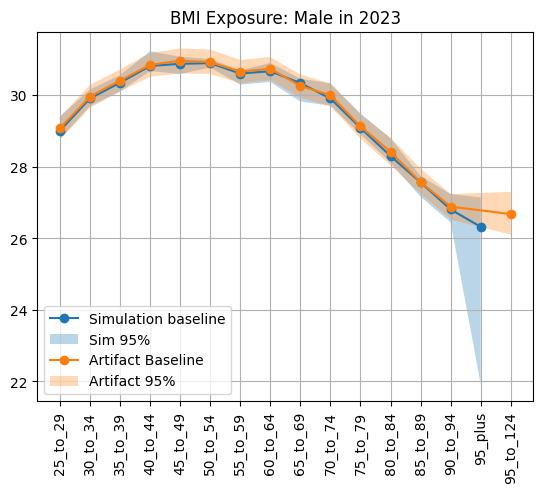

In [24]:
for sex in bmi_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['50%'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'BMI Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

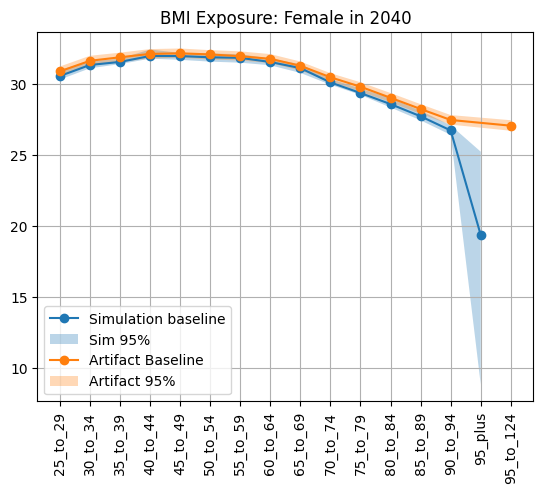

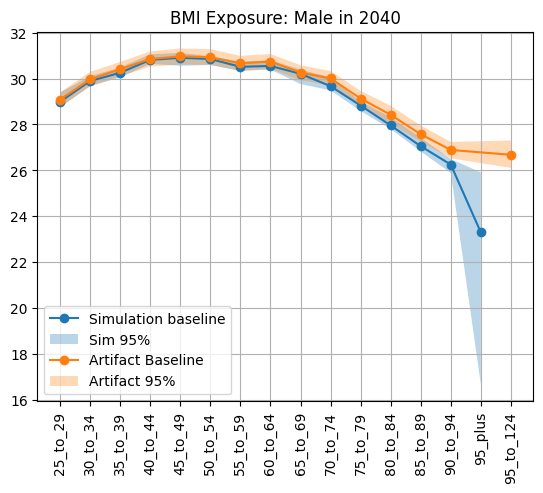

In [25]:
for sex in bmi_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = bmi_exp_rate_summ.loc[(bmi_exp_rate_summ.sex==sex) & (bmi_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['50%'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'BMI Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### SBP

In [26]:
sbp_art = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure')
sbp_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_art.age_start,sbp_art.age_end)]
sbp_art.head()

sex  age_start  age_end  year_start  year_end   parameter        mean  \
0  Female       25.0     30.0        2019      2020  continuous  110.635893   
1  Female       30.0     35.0        2019      2020  continuous  112.876275   
2  Female       35.0     40.0        2019      2020  continuous  116.139886   
3  Female       40.0     45.0        2019      2020  continuous  118.491616   
4  Female       45.0     50.0        2019      2020  continuous  121.645391   

          50%        2.5%       97.5% location   measure age_group  
0  110.623634  107.945700  113.550750  Alabama  exposure  25_to_29  
1  112.881309  110.098198  115.523727  Alabama  exposure  30_to_34  
2  116.134678  113.594023  118.770064  Alabama  exposure  35_to_39  
3  118.514616  115.903577  121.039457  Alabama  exposure  40_to_44  
4  121.618436  118.875235  124.529834  Alabama  exposure  45_to_49

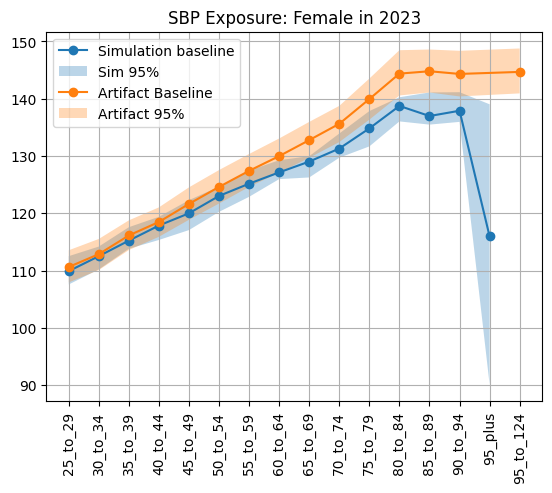

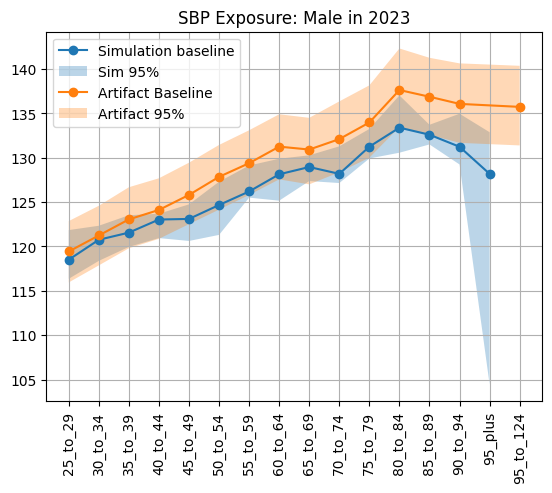

In [27]:
for sex in sbp_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2023')
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

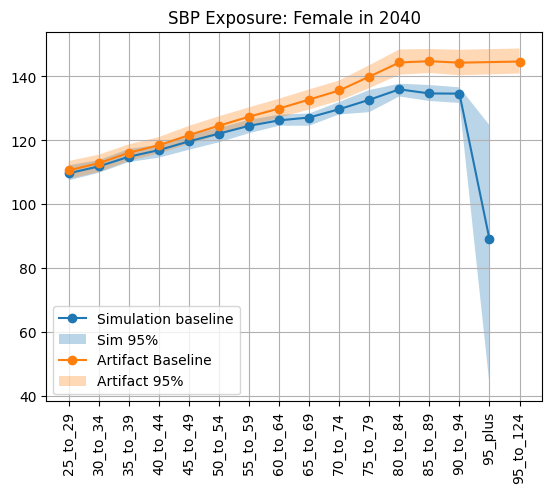

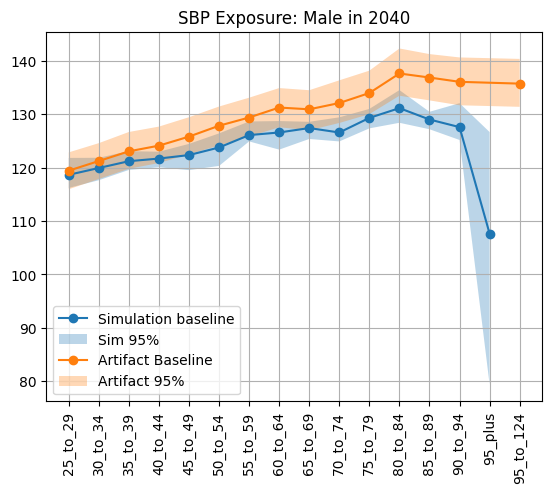

In [28]:
for sex in sbp_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = sbp_exp_rate_summ.loc[(sbp_exp_rate_summ.sex==sex) & (sbp_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### LDL-C

In [29]:
ldl_art = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure')
ldl_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_art.age_start,ldl_art.age_end)]
ldl_art.head()

sex  age_start  age_end  year_start  year_end   parameter      mean  \
0  Female       25.0     30.0        2019      2020  continuous  2.639862   
1  Female       30.0     35.0        2019      2020  continuous  2.724353   
2  Female       35.0     40.0        2019      2020  continuous  2.802925   
3  Female       40.0     45.0        2019      2020  continuous  2.880791   
4  Female       45.0     50.0        2019      2020  continuous  2.998297   

        50%      2.5%     97.5% location   measure age_group  
0  2.638003  2.472574  2.821188  Alabama  exposure  25_to_29  
1  2.723671  2.553736  2.905134  Alabama  exposure  30_to_34  
2  2.801341  2.639513  2.972487  Alabama  exposure  35_to_39  
3  2.878250  2.721814  3.039119  Alabama  exposure  40_to_44  
4  2.995129  2.837974  3.175367  Alabama  exposure  45_to_49

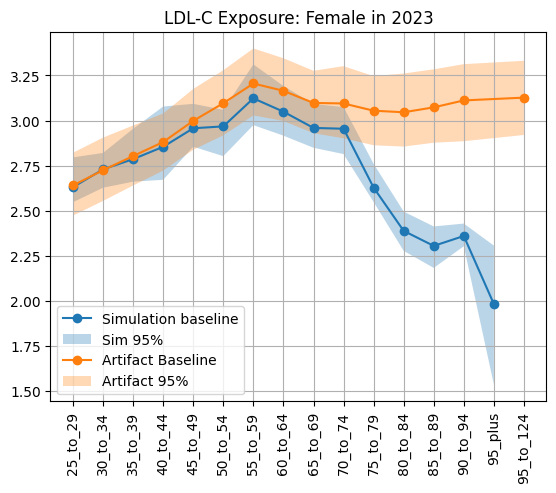

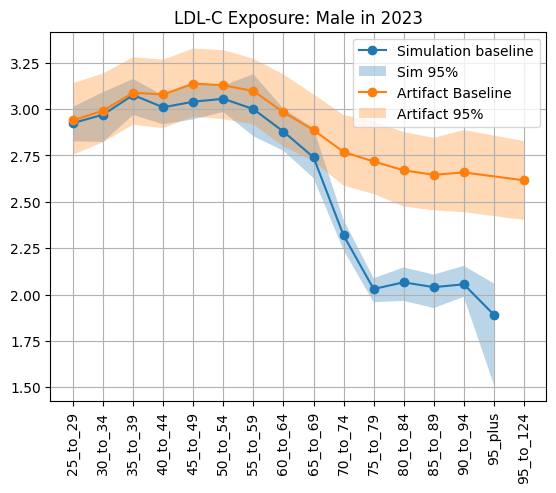

In [30]:
for sex in ldl_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL-C Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

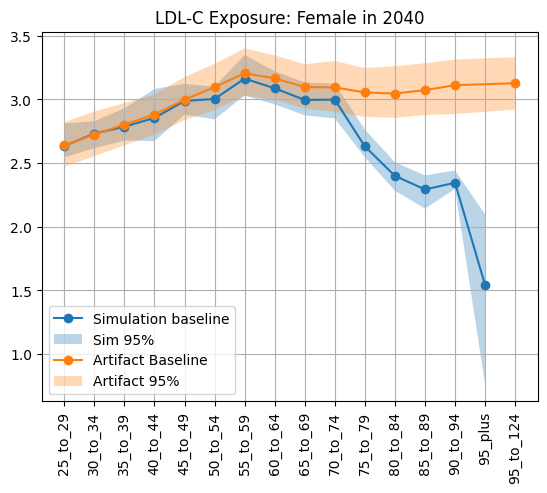

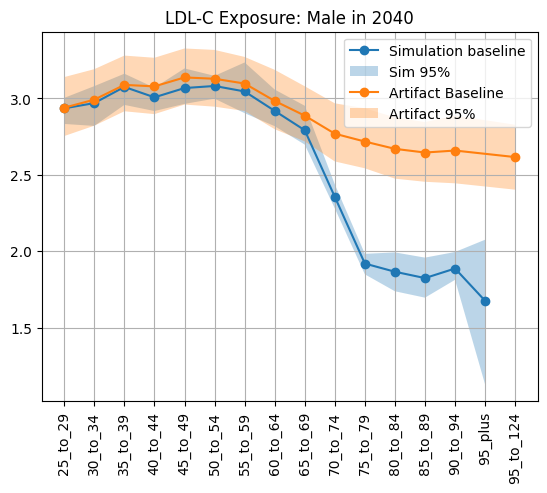

In [31]:
for sex in ldl_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL-C Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### FPG

In [32]:
fpg_art = load_artifact_data('risk_factor', 'high_fasting_plasma_glucose', 'exposure')
fpg_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(fpg_art.age_start,fpg_art.age_end)]
fpg_art.head()

sex  age_start  age_end  year_start  year_end   parameter      mean  \
0  Female       25.0     30.0        2019      2020  continuous  5.316303   
1  Female       30.0     35.0        2019      2020  continuous  5.461718   
2  Female       35.0     40.0        2019      2020  continuous  5.538952   
3  Female       40.0     45.0        2019      2020  continuous  5.659873   
4  Female       45.0     50.0        2019      2020  continuous  5.787248   

        50%      2.5%     97.5% location   measure age_group  
0  5.307507  4.613215  6.137399  Alabama  exposure  25_to_29  
1  5.447329  4.696085  6.297658  Alabama  exposure  30_to_34  
2  5.538472  4.750516  6.371252  Alabama  exposure  35_to_39  
3  5.650779  4.873814  6.494619  Alabama  exposure  40_to_44  
4  5.771666  5.004493  6.682187  Alabama  exposure  45_to_49

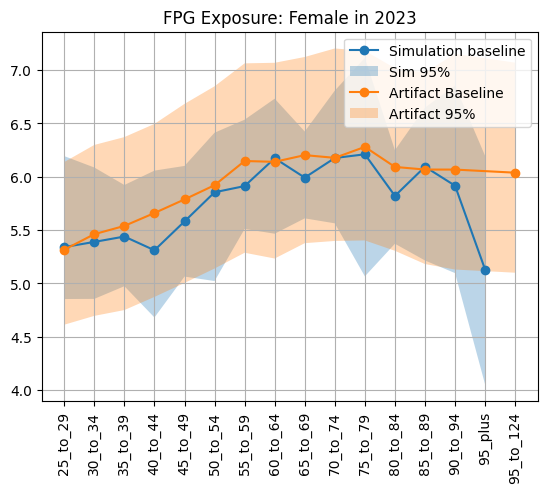

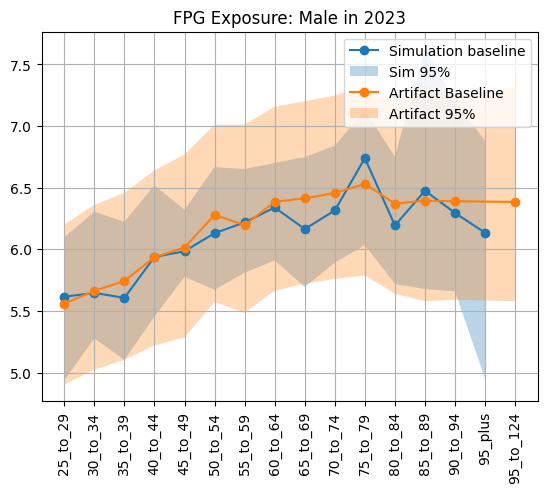

In [33]:
for sex in fpg_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = fpg_art.loc[(fpg_art.sex==sex) & (fpg_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'FPG Exposure: {sex} in 2023')
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

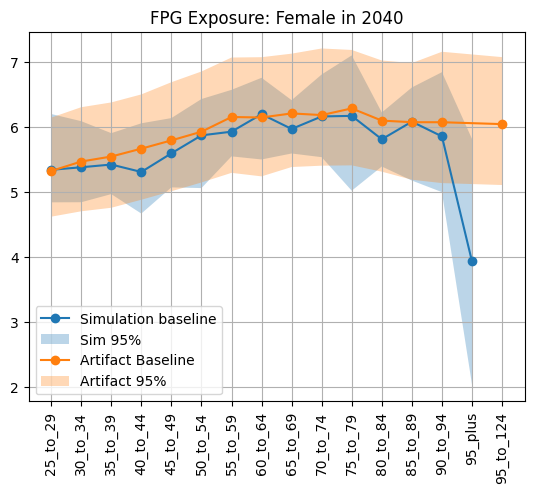

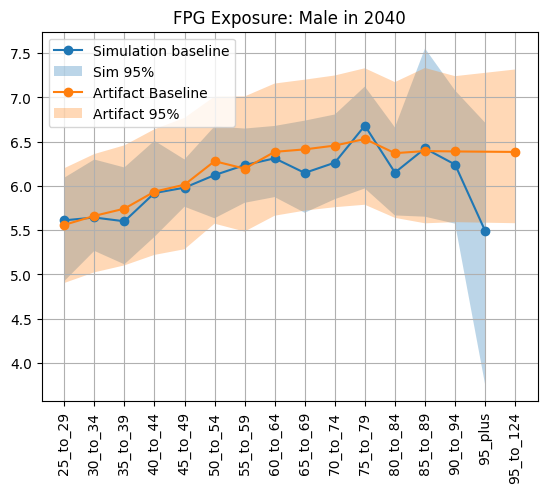

In [34]:
for sex in fpg_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = fpg_art.loc[(fpg_art.sex==sex) & (fpg_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'FPG Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Very interestingly (and almost worse overall) FPG is working great while the other 3 are looking bad

### Checking on the oldest folks 

In [37]:
bmi_oldest = bmi_exp_rate.loc[(bmi_exp_rate['age']=='95_plus') & (bmi_exp_rate['year']==2040)]

In [38]:
bmi_oldest.sort_values('bmi_rate')

age     sex  year  input_draw         value     ptvalue   bmi_rate
5216  95_plus  Female  2040         650   4760.520226  548.347707   8.681572
5214  95_plus  Female  2040         602   6017.341779  650.458590   9.250922
5213  95_plus  Female  2040         394   7111.355442  552.334018  12.875100
5391  95_plus    Male  2040         232   5482.964009  329.560575  16.637196
...       ...     ...   ...         ...           ...         ...        ...
5397  95_plus    Male  2040         680   6071.675933  236.342231  25.690186
5395  95_plus    Male  2040         629   5357.771508  208.208077  25.732775
5396  95_plus    Male  2040         650   6116.339434  235.575633  25.963379
5215  95_plus  Female  2040         629  13371.639196  510.401095  26.198296

[20 rows x 7 columns]